# Data and preparation

In [1]:
# Modules
import numpy as np
import rasterio
import sys

sys.path.insert(0, "..")
from eis_toolkit.exceptions import NumericValueSignException, InvalidParameterValueException, InvalidInputDataException
from eis_toolkit.transformations import binarize, logarithmic, linear, sigmoid, winsorize

# Supress scientific notation
np.set_printoptions(suppress=True)


In [2]:
# Raster data
image_small_mb4 = rasterio.open("/eis_toolkit/tests/data/remote/small_raster_multiband.tif")                      # multiband raster with 4 bands


# General
## Raster data
- Testing on raster **with** nan-value in meta data
- Testing on raster **without** nan-values in meta data
- Testing **multi-band**-support

## DataFrames
- Core functions will be the same as for raster data, so that only the "branching" needs to be tested

## General exceptions
Set <code>raise_exception = True</code> for **test** and **debugging** only

### Raster data

In [3]:
test_image = image_small_mb4

In [4]:
raise_exception = False

In [5]:
# Selection data type
if raise_exception: binarize.binarize(in_data=test_image, selection=["e"], thresholds=[2], nodata=None, method="replace")

In [6]:
# Selection data type
if raise_exception: binarize.binarize(in_data=test_image, selection=[1.2], thresholds=[2], nodata=None, method="replace")

In [7]:
# Selection is zero
if raise_exception: binarize.binarize(in_data=test_image, selection=[0], thresholds=[2], nodata=None, method="replace")


In [8]:
# Selection same values (not unique)
if raise_exception: binarize.binarize(in_data=test_image, selection=[1, 1], thresholds=[2], nodata=None, method="replace")


In [9]:
# Selection length
if raise_exception: binarize.binarize(in_data=test_image, selection=[1, 2, 3, 4, 5], thresholds=[2], nodata=None, method="replace")

In [10]:
# Output method
if raise_exception: binarize.binarize(in_data=test_image, selection=[1], thresholds=[2], nodata=None, method="nothing")


In [11]:
# NoData length
if raise_exception: binarize.binarize(in_data=test_image, selection=None, thresholds=[2], nodata=[1, 2], method="replace")


In [12]:
# NoData length
if raise_exception: binarize.binarize(in_data=test_image, selection=[1, 2], thresholds=[2], nodata=[1, 2, 3], method="replace")


# Binarize
## Info
- sets values <code><\= threshold</code> to **0** and <code>> threshold</code> to **1**
- **NoData** -values will be ignored during transformation (values will be kept in the result)

## Arguments
- selection: bands can be **None** or a list of **int**, **float**, **None** values
- thresholds: a list of **int** or **float** values
- nodata: either **None** or a list of **int** and **float**
- method: kind of output of the transformed data, either overwriting the existing ones ("**replace**") or extraction of selected bands ("**extract**")



## Data

In [13]:
test_image = image_small_mb4


## Exceptions
Set <code>raise_exception = True</code> for **test** and **debugging** only

In [14]:
raise_exception = False

In [15]:
# Treshold length
if raise_exception: binarize.binarize(in_data=test_image, selection=None, thresholds=[2, 3], nodata=None, method="replace")


In [16]:
# Treshold length
if raise_exception: binarize.binarize(in_data=test_image, selection=[1], thresholds=[2, 3], nodata=None, method="replace")


In [17]:
# Treshold data type
if raise_exception: binarize.binarize(in_data=test_image, selection=None, thresholds=["a"], nodata=None, method="replace")


## Examples

### **Change** values **in place** 
**Overwrite existing** data for specific **bands**

#### **All** bands, **same** threshold, NoData **read-in**

In [18]:
image, meta, settings = binarize.binarize(in_data=test_image, selection=None, thresholds=[2], nodata=None, method="replace")


#### **Single** band, **single** threshold, NoData **read-in**

In [19]:
image, meta, settings = binarize.binarize(in_data=test_image, selection=[3], thresholds=[5], nodata=None, method="replace")


#### **Multi-** selection, **single** threshold, NoData **read-in**

In [20]:
image, meta, settings = binarize.binarize(in_data=test_image, selection=[1, 3], thresholds=[2], nodata=None, method="replace")


#### **Multi-** selection, **multi-** treshold, NoData **read-in**

In [21]:
image, meta, settings = binarize.binarize(in_data=test_image, selection=[1, 3, 4], thresholds=[2, 0, 1], nodata=None, method="replace")


#### **Multi-** selection, **multi-** treshold, **single** NoData

In [22]:
image, meta, settings = binarize.binarize(in_data=test_image, selection=[1, 2, 3, 4], thresholds=[-5, -2, 2, 5], nodata=[-10], method="replace")


#### **Multi-** selection, **multi-** treshold, **multi-** NoData (**mixed**)
NoData **specified** and **read-in**

In [23]:
image, meta, settings = binarize.binarize(in_data=test_image, selection=[1, 2, 3, 4], thresholds=[-5, -2, 2, 5], nodata=[2.749, None, None, None], method="replace")


#### **Unordered multi-** selection, **multi-** threshold, **multi-** NoData
**Unordered** band selection does **not** affect the order of the resulting output

In [24]:
image, meta, settings = binarize.binarize(in_data=test_image, selection=[3, 1, 4], thresholds=[5, 2, 0], nodata=[1.771, 2.749, -0.766], method="replace")


### **Change** values and **extract** selected bands in **specified order** 
Works like the replace method, however, the result will **only contain** the transformation of the **specified** bands

#### **Multi-** selection, **single** threshold, NoData **read-in**

In [25]:
image, meta, settings = binarize.binarize(in_data=test_image, selection=[3, 1], thresholds=[5], nodata=None, method="extract")


#### **Unordered multi-** selection, **multi-** threshold, **multi-** NoData (**mixed**)
NoData **specified** and **read-in** <br>
**Unordered** band selection **does** affect the order of the resulting output

Example:
- in band 3 = out band 1, threshold 5, nodata 1.771
- in band 1 = out band 2, threshold 1, nodata **read-in**
- in band 4 = out band 3, threshold 2, nodata -0.766

In [26]:
image, meta, settings = binarize.binarize(in_data=test_image, selection=[3, 1, 4], thresholds=[5, 1, 0], nodata=[1.771, None, -0.766], method="extract")


# Logarithmic
## Info
- transforms data into logarithmic space
- **NoData** -values will be ignored during transformation (values will be kept in the result)
- <code>values below or equal to 0 </code> will be handled like **NoData**
- <code>Inf</code> -values will also be handled as **NoData**

If such values occur and the method above does not suits the users needs, data have to be **cleaned in advance** to the transformation

## Arguments
- selection: bands can be **None** or a list of **int**, **float**, **None** values
- base: a list containing either 2 or 10
- nodata: either **None** or a list of **int** and **float**
- method: kind of output of the transformed data, either overwriting the existing ones ("**replace**") or extraction of selected bands ("**extract**")


## Data

In [28]:
test_image = image_small_mb4

## Exceptions
Set <code>raise_exception = True</code> for **test** and **debugging** only <br>
Exceptions to test the inputs for the **selection** argument are contained in the *binarize* section

In [29]:
raise_exception = False

In [30]:
# Base length
if raise_exception: logarithmic.log_transform(in_data=test_image, selection=None, base=[2, 2], nodata=None, method="replace")


In [31]:
# Base length
if raise_exception: logarithmic.log_transform(in_data=test_image, selection=[1], base=[2, 2], nodata=None, method="replace")


In [32]:
# Base data type
if raise_exception: logarithmic.log_transform(in_data=test_image, selection=None, base=["a"], nodata=None, method="replace")


In [33]:
# Base value
if raise_exception: logarithmic.log_transform(in_data=test_image, selection=None, base=[3], nodata=None, method="replace")


## Examples

### **Change** values **in place** 
**Overwrite existing** data for specific **bands**

#### **All** bands, **single** base, NoData **read-in**

In [34]:
image, meta, settings = logarithmic.log_transform(in_data=test_image, selection=None, base=[2], nodata=None, method="replace")


#### **Single** band, **single** base, NoData **read-in**

In [35]:
image, meta, settings = logarithmic.log_transform(in_data=test_image, selection=[3], base=[2], nodata=None, method="replace")


#### **Multi-** selection, **single** base, NoData **read-in**

In [36]:
image, meta, settings = logarithmic.log_transform(in_data=test_image, selection=[1, 3], base=[2], nodata=None, method="replace")


#### **Multi-** selection, **multi-** base, NoData **read-in**

In [37]:
image, meta, settings = logarithmic.log_transform(in_data=test_image, selection=[1, 3, 4], base=[2, 10, 2], nodata=None, method="replace")


#### **Multi-** selection, **multi-** base, **single** NoData

In [38]:
image, meta, settings = logarithmic.log_transform(in_data=test_image, selection=[1, 2, 3, 4], base=[2, 2, 10, 10], nodata=[-10], method="replace")


#### **Multi-** selection, **multi-** base, **multi-** NoData (**mixed**)
NoData **specified** and **read-in**

In [39]:
image, meta, settings = logarithmic.log_transform(in_data=test_image, selection=[1, 2, 3, 4], base=[2, 2, 10, 10], nodata=[2.749, None, None, None], method="replace")


#### **Unordered multi-** selection, **multi-** base, **multi-** NoData
**Unordered** band selection does **not** affect the order of the resulting output

In [40]:
image, meta, settings = logarithmic.log_transform(in_data=test_image, selection=[3, 1, 4], base=[2, 2, 10], nodata=[1.771, 2.749, -0.766], method="replace")


### **Change** values and **extract** selected bands in **specified order** 
Works like the replace method, however, the result will **only contain** the transformation of the **specified** bands

#### **Multi-** selection, **single** base, NoData **read-in**

In [41]:
image, meta, settings = logarithmic.log_transform(in_data=test_image, selection=[3, 1], base=[10], nodata=None, method="extract")


#### **Unordered multi-** selection, **multi-** base, **multi-** NoData (**mixed**)
NoData **specified** and **read-in** <br>
**Unordered** band selection **does** affect the order of the resulting output

Example:
- in band 3 = out band 1, base 2, nodata 1.771
- in band 1 = out band 2, base 2, nodata **read-in**
- in band 4 = out band 3, base 10, nodata -0.766

In [42]:
image, meta, settings = logarithmic.log_transform(in_data=test_image, selection=[3, 1, 4], base=[2, 2, 10], nodata=[1.771, None, -0.766], method="extract")


# Linear

## Z-score normalization
### Info
- appies z-score normalization (transforms data based on **mean** and **standard deviation**)
- **NoData** -values will be ignored during transformation (values will be kept in the result)
- <code>Inf</code> -values will be handled as **NoData**

If such values occur and the method above does not suits the users needs, data have to be **cleaned in advance** to the transformation

### Arguments
- selection: bands can be **None** or a list of **int**, **float**, **None** values
- with_mean: using the **data mean** if **True**, **else** set mean to **zero** (default set to **True**)
- with_sd: using the **data sd** if **True**, **else** set standard deviation to **1** (default set to **True**)
- nodata: either **None** or a list of **int** and **float**
- method: kind of output of the transformed data, either overwriting the existing ones ("**replace**") or extraction of selected bands ("**extract**")

### Exceptions

In [44]:
raise_exception = False

In [45]:
# with_mean length
if raise_exception: image, meta, settings = linear.z_score_norm(in_data=test_image, selection=None, with_mean=[True, False], with_sd=[True], nodata=None, method="replace")


In [46]:
# with_sd length
if raise_exception: image, meta, settings = linear.z_score_norm(in_data=test_image, selection=None, with_mean=[True], with_sd=[True, False], nodata=None, method="replace")


In [47]:
# with_mean/sd length
if raise_exception: image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[1, 2, 3], with_mean=[True, False], with_sd=[True, False], nodata=None, method="replace")


In [48]:
# with_mean data type
if raise_exception: image, meta, settings = linear.z_score_norm(in_data=test_image, selection=None, with_mean=["a"], with_sd=[True], nodata=None, method="replace")


In [49]:
# with_sd data type
if raise_exception: image, meta, settings = linear.z_score_norm(in_data=test_image, selection=None, with_mean=[True], with_sd=[1], nodata=None, method="replace")


### Examples

#### **Change** values **in place** 
**Overwrite existing** data for specific **bands**

##### **All** bands, **single** mean/sd, NoData **read-in**

In [50]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=None, with_mean=[True], with_sd=[True], nodata=None, method="replace")


##### **Single** band, **single** mean/sd, NoData **read-in**

In [51]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[1], with_mean=[True], with_sd=[True], nodata=None, method="replace")


##### **Multi-** selection, **single** mean/sd, NoData **read-in**

In [52]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[1, 3], with_mean=[True], with_sd=[True], nodata=None, method="replace")


##### **Multi-** selection, **multi-** mean/sd, NoData **read-in**

In [53]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[1, 3, 4], with_mean=[True, True, False], with_sd=[True, True, False], nodata=None, method="replace")


##### **Multi-** selection, **multi-** mean and **single** sd, NoData **read-in**

In [54]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[1, 3, 4], with_mean=[True, True, False], with_sd=[True], nodata=None, method="replace")


##### **Multi-** selection, **single** mean and **multi-** sd, NoData **read-in**

In [55]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[1, 3, 4], with_mean=[True], with_sd=[True, True, False], nodata=None, method="replace")


##### **Multi-** selection, **multi-** mean/sd (not symmetric), **single** NoData

In [56]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[1, 2, 3, 4], with_mean=[True, False, True, False], with_sd=[False, True, False, True], nodata=[-10], method="replace")


##### **Multi-** selection, **multi-** mean/sd, **multi-** NoData (**mixed**)
NoData **specified** and **read-in**

In [57]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[1, 2, 3, 4], with_mean=[True, True, False, False], with_sd=[True, True, False, False], nodata=[2.749, None, None, None], method="replace")


##### **Unordered multi-** selection, **multi-** mean/sd, **multi-** NoData
**Unordered** band selection does **not** affect the order of the resulting output

In [58]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[3, 1, 4], with_mean=[True, True, False], with_sd=[True, True, False], nodata=[1.771, 2.749, -0.766], method="replace")


#### **Change** values and **extract** selected bands in **specified order** 
Works like the replace method, however, the result will **only contain** the transformation of the **specified** bands

##### **Multi-** selection, **single** mean/sd, NoData **read-in**

In [59]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[3, 1], with_mean=[True], with_sd=[True], nodata=None, method="extract")


##### **Unordered multi-** selection, **multi-** mean/sd, **multi-** NoData (**mixed**)
NoData **specified** and **read-in** <br>
**Unordered** band selection **does** affect the order of the resulting output

Example:
- in band 3 = out band 1, mean/sd True, nodata 1.771
- in band 1 = out band 2, mean/sd True, nodata **read-in**
- in band 4 = out band 3, mean/sd False, nodata -0.766

In [60]:
image, meta, settings = linear.z_score_norm(in_data=test_image, selection=[3, 1, 4], with_mean=[True, True, False], with_sd=[True, True, False], nodata=[1.771, None, -0.766], method="extract")


## Min-max-scaling
### Info
- transforms data into a new specified value-range
- **NoData** -values will be ignored during transformation (values will be kept in the result)
- <code>Inf</code> -values will be handled as **NoData**

If such values occur and the method above does not suits the users needs, data have to be **cleaned in advance** to the transformation

### Arguments
- selection: bands can be **None** or a list of **int**, **float**, **None** values
- new_range: tuple containing the desired new minimum and maximum
    - defaults **(0, 1)**
    - order must be <code>(min, max)</code>
    - <code>min < max</code> required
- nodata: either **None** or a list of **int** and **float**
- method: kind of output of the transformed data, either overwriting the existing ones ("**replace**") or extraction of selected bands ("**extract**")

### Exceptions

In [62]:
raise_exception = False

In [63]:
# new_range length
if raise_exception: image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=None, new_range=[(0, 1), (0, 1)], nodata=None, method="replace")


In [64]:
# new_range data type
if raise_exception: image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=None, new_range=[("a", 1)], nodata=None, method="replace")


In [65]:
# new_range min/max order (min > max)
if raise_exception: image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=None, new_range=[(1, 0)], nodata=None, method="replace")


In [66]:
# new_range min/max equal (min == max, but same exception as for min > max)
if raise_exception: image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=None, new_range=[(0, 0)], nodata=None, method="replace")


In [67]:
# new_range value count
if raise_exception: image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=None, new_range=[(0, 1, 1)], nodata=None, method="replace")


### Examples

#### **Change** values **in place** 
**Overwrite existing** data for specific **bands**

##### **All** bands, **single** range, NoData **read-in**

In [68]:
image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=None, new_range=[(0, 1)], nodata=None, method="replace")


##### **Single** band, **single** range, NoData **read-in**

In [69]:
image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=[1], new_range=[(0, 1)], nodata=None, method="replace")


##### **Multi-** selection, **single** range, NoData **read-in**

In [70]:
image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=[1, 3], new_range=[(0, 1)], nodata=None, method="replace")


##### **Multi-** selection, **multi-** range, NoData **read-in**

In [71]:
image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=[1, 3, 4], new_range=[(0, 1), (1, 10), (10,100)], nodata=None, method="replace")


##### **Multi-** selection, **multi-** range, **single** NoData

In [72]:
image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=[1, 2, 3, 4], new_range=[(0, 1), (1, 10), (10,100), (100, 1000)], nodata=[-10], method="replace")


##### **Multi-** selection, **multi-** range, **multi-** NoData (**mixed**)
NoData **specified** and **read-in**

In [73]:
image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=[1, 2, 3, 4], new_range=[(0, 1), (1, 10), (10,100), (100, 1000)], nodata=[2.749, None, None, None], method="replace")


##### **Unordered multi-** selection, **multi-** range, **multi-** NoData
**Unordered** band selection does **not** affect the order of the resulting output

In [74]:
image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=[3, 1, 4], new_range=[(10,100), (0,1), (100, 1000)], nodata=[1.771, 2.749, -0.766], method="replace")


#### **Change** values and **extract** selected bands in **specified order** 
Works like the replace method, however, the result will **only contain** the transformation of the **specified** bands

##### **Multi-** selection, **single** range, NoData **read-in**

In [75]:
image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=[3, 1], new_range=[(0, 1)], nodata=None, method="extract")


##### **Unordered multi-** selection, **multi-** range, **multi-** NoData (**mixed**)
NoData **specified** and **read-in** <br>
**Unordered** band selection **does** affect the order of the resulting output

Example:
- in band 3 = out band 1, range (10, 100), nodata 1.771
- in band 1 = out band 2, range (0, 1), nodata **read-in**
- in band 4 = out band 3, range (100, 1000), nodata -0.766

In [76]:
image, meta, settings = linear.minmax_scaling(in_data=test_image, selection=[3, 1, 4], new_range=[(10, 100), (0, 1), (100, 1000)], nodata=[1.771, None, -0.766], method="extract")


# Sigmoid transform
## Info
- applies sigmoid transformation on a specified data set
- **NoData** -values will be ignored during transformation (values will be kept in the result)
- <code>Inf</code> -values will be handled as **NoData**

If such values occur and the method above does not suits the users needs, data have to be **cleaned in advance** to the transformation

## Arguments
- selection: bands can be **None** or a list of **int**, **float**, **None** values
- new_range: list of tuples containing the desired new minimum and maximum
    - defaults **(0, 1)**
    - order must be <code>(min, max)</code>
    - <code>min < max</code> required
- shift: tuple containing **int** or **float** -values to shift the data on the respective axis
    - defaults **(0, 0)**
    - must be in <code>(x, y)</code> order
    - if only one axis needs to be shifted, use **zero** for the other: e.g. for <code>x + 2</code>, use **(2, 0)**
    - **positive x** values will shift to the **right**, **positive y** values will shift **downwards** the y-axis
    - **negative x** values will shift to the **left**, **negative y** values will shift **upwards** the y-axis
- slope: list of **int** or **float** values for the slope of the resulting curve
    - default value is **1**
    - slope of **zero** results in a horizontal line between new_range(min, max) plus additional shift
- nodata: either **None** or a list of **int** and **float**
- method: kind of output of the transformed data, either overwriting the existing ones ("**replace**") or extraction of selected bands ("**extract**")

## Visualization

### Data

In [78]:
import numpy as np
import pandas as pd

# small data sets
small_array = np.random.randint(0, 10, (5, 5))
small_df = pd.DataFrame(small_array.T)

# large data sets
large_array = np.random.randint(0, 10, (10000, 10000))
large_df = pd.DataFrame(large_array.T)

# set working data sets
array = large_array
df = small_df

### Transformation

In [79]:
def numpy_sigmoid(array, new_range=(0, 1), shift=(0, 0), slope=1):
  scaled_sigmoid = new_range[0] + (new_range[1] - new_range[0]) * (1 / (1 + np.exp(-slope*(array-shift[0])))) - shift[1]
  return scaled_sigmoid


### Plot

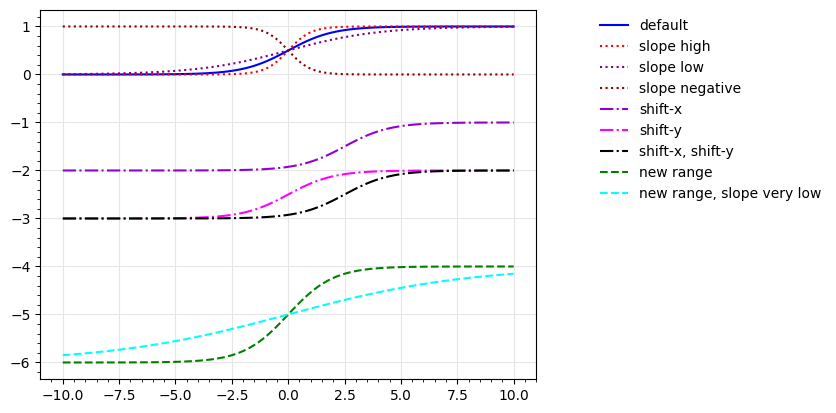

In [80]:
import matplotlib.pyplot as plt
array = np.linspace(-10, 10, 100)

# Transformations
sigmoid_default = numpy_sigmoid(array)
sigmoid_range = numpy_sigmoid(array, new_range=(-6, -4))
sigmoid_slope_high = numpy_sigmoid(array, slope=2)
sigmoid_slope_low = numpy_sigmoid(array, slope=0.5)
sigmoid_slope_neg = numpy_sigmoid(array, slope=-2)
sigmoid_range_slope_vlow = numpy_sigmoid(array, new_range=(-6, -4), slope=0.25)
sigmoid_shift_x = numpy_sigmoid(array, new_range=(-2, -1), shift=(2.5, 0))
sigmoid_shift_y = numpy_sigmoid(array, new_range=(-2, -1), shift=(0, 1)) 
sigmoid_shift_x_y = numpy_sigmoid(array, new_range=(-2, -1), shift=(2.5, 1))  

# Plots
plt.plot(array, sigmoid_default, "blue", linestyle="solid", label="default")
plt.plot(array, sigmoid_slope_high, "red", linestyle="dotted", label="slope high")
plt.plot(array, sigmoid_slope_low, "purple", linestyle="dotted", label="slope low")
plt.plot(array, sigmoid_slope_neg, "darkred", linestyle="dotted", label="slope negative")

plt.plot(array, sigmoid_shift_x, "darkviolet", linestyle="dashdot", label="shift-x")
plt.plot(array, sigmoid_shift_y, "magenta", linestyle="dashdot", label="shift-y")
plt.plot(array, sigmoid_shift_x_y, "black", linestyle="dashdot", label="shift-x, shift-y")

plt.plot(array, sigmoid_range, "green", linestyle="dashed", label="new range")
plt.plot(array, sigmoid_range_slope_vlow, "cyan", linestyle="dashed", label="new range, slope very low")

plt.legend(loc="lower right", frameon=False, bbox_to_anchor=(1.6, 0.45))
plt.minorticks_on()
plt.grid(True, color="0.9")
plt.show();

## Exceptions

In [81]:
raise_exception = False

In [82]:
# new_range length
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(0, 1), (0, 1)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


In [83]:
# new_range length
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[1, 2], new_range=[(0, 1), (0, 1), (0, 1)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


In [84]:
# shift length
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(0, 1)], shift=[(0, 0), (0, 0)], slope=[1], nodata=None, method="replace")


In [85]:
# slope length
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(0, 1)], shift=[(0, 0)], slope=[1, 1], nodata=None, method="replace")


In [86]:
# new_range data type
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[("a", 1)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


In [87]:
# new_range values length
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(1, 1, 1)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


In [88]:
# new_range min/max order (min > max)
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(2, 1)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


In [89]:
# new_range min/max equal (min == max, but same exception as for min > max)
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(1, 1)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


In [90]:
# shift values data type
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(0, 1)], shift=[(0, "a")], slope=[1], nodata=None, method="replace")


In [91]:
# shift values length
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(0, 1)], shift=[(0, 0, 0)], slope=[1], nodata=None, method="replace")


In [92]:
# slope values data type
if raise_exception: image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(0, 1)], shift=[(0, 0)], slope=["a"], nodata=None, method="replace")


## Examples

### **Change** values **in place** 
**Overwrite existing** data for specific **bands**

#### **All** bands, **single** range, shift and slope, NoData **read-in**

In [93]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=None, new_range=[(0, 1)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


#### **Single** band, **single** range, shift and slope, NoData **read-in**

In [94]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[1], new_range=[(0, 1)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


#### **Multi-** selection, **single** range, shift and slope, NoData **read-in**

In [95]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[1, 3], new_range=[(0, 1)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


#### **Multi-** selection, **multi-** range, **single** shift and slope, NoData **read-in**

In [96]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[1, 3, 4], new_range=[(0, 1), (1, 10), (10,100)], shift=[(0, 0)], slope=[1], nodata=None, method="replace")


#### **Multi-** selection, **single-** range and slope, **multi-** shift, NoData **read-in**

In [97]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[1, 3, 4], new_range=[(0, 1)], shift=[(0, 0), (0, 1), (-1, -1)], slope=[1], nodata=None, method="replace")


#### **Multi-** selection, **single-** range and shift, **multi** slope, NoData **read-in**

In [98]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[1, 3, 4], new_range=[(0, 1)], shift=[(0, 0)], slope=[1, 1, -1], nodata=None, method="replace")


#### **Multi-** selection, **multi-** range, **single** shift and slope, **single** NoData

In [99]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[1, 3, 4], new_range=[(0, 1), (1, 10), (10,100)], shift=[(0, 0)], slope=[1], nodata=[-10], method="replace")


#### **Multi-** selection, **multi-** range, shift and slope, **multi-** NoData (**mixed**)
NoData **specified** and **read-in**

In [100]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[1, 2, 3, 4], new_range=[(0, 1), (1, 10), (10,100), (100, 1000)],
                                                  shift=[(0, 0), (0, 1), (1, 0), (1, 1)],
                                                  slope=[1, -1, 1, 0],
                                                  nodata=[2.749, None, None, None], method="replace")


#### **Unordered multi-** selection, **multi-** range, **multi-** NoData
**Unordered** band selection does **not** affect the order of the resulting output

In [101]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[3, 1, 4], new_range=[(10, 100), (0, 1), (100, 1000)],
                                                  shift=[(1, 0), (0, 0), (1, 1)],
                                                  slope=[1, 1, 0],
                                                  nodata=[1.771, 2.749, -0.766], method="replace")


### **Change** values and **extract** selected bands in **specified order** 
Works like the replace method, however, the result will **only contain** the transformation of the **specified** bands

#### **Multi-** selection, **single** range, shift and slope, NoData **read-in**

In [102]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[3, 1], new_range=[(0, 1)], shift=[(0, 0)], slope=[1], nodata=None, method="extract")


#### **Unordered multi-** selection, **multi-** range, **multi-** NoData (**mixed**)
NoData **specified** and **read-in** <br>
**Unordered** band selection **does** affect the order of the resulting output

Example:
- in band 3 = out band 1, range (10, 100), shift (1, 0), slope 1, nodata 1.771
- in band 1 = out band 2, range (0, 1), shift (0, 0), slope 1, nodata **read-in**
- in band 4 = out band 3, range (100, 1000), shift (1, 1), slope 0, nodata -0.766

In [103]:
image, meta, settings = sigmoid.sigmoid_transform(in_data=test_image, selection=[3, 1, 4], new_range=[(10, 100), (0, 1), (100, 1000)],
                                                  shift=[(1, 0), (0, 0), (1, 1),],
                                                  slope=[1, 1, 0],
                                                  nodata=[1.771, None, -0.766], method="extract")


# Winsorize

## Info
- replaces values below/above a given threshold with new values
- **NoData** -values will be ignored during transformation (values will be kept in the result)

## Arguments
- selection: bands can be **None** or a list of **int**, **float**, **None** values
- replace_type: string, either **"absolute"** or **"percentiles"**
    - required to choose whether winsorize should be executed with **absolute** thresholds or based on given **percentiles**
    - **global** option
- if <code>replace_type == "absolute"</code>
    - limits: list of tuples containing **int**, **float** or **None** values
       - e.g. **(100, None)**, which selects only values < 100 to be changed
       - order must be <code>(min, max)</code>
       - <code>min < max </code>
    - replace_values: list of tuples containing **int**, **float** or **None** values
        - order must be <code>(min, max)</code>
        - <code>min < max </code>
        - position of **NoneType** entries must match those from **limits**
- if <code>replace_type == "percentiles"</code>
     - limits: list of tuples containing **int**, **float** or **None** values
       - e.g. **(10, 25)**, which selects the lower 10% and upper 25% values of the data set (0-10 for lower and 75-100 for upper, values between 10-75 percentiles remain unchanged)
       - order must be <code>(lower, upper)</code>
       - replacement values will be calculated at the border of the specified interval
       - <code>lower + upper < 100</code>
    - replace_position: list containing a string, either **"inside"** or "**outside**", to choose whether to take the value for replacement from **inside** or **outside** a calculated percentile interval
      - e.g. if the lower threshold is set to 10% and the corresponding calculated value is 20, but the nearest data values are 19 and 21:
         - if **inside**: all data <code>< 20</code> will be replaced with **19**
         - if **outside**: all data <code>< 20</code> will be replaced with **21**
      - e.g. if the upper threshold is set to 10% and the corresponding calculated value is 80, but the nearest data values are 79 and 81:
         - if **inside**: all data <code>> 80</code> will be replaced with **81**
         - if **outside**: all data <code>> 80</code> will be replaced with **79**
      - default **outside**
- nodata: either **None** or a list of **int** and **float**
- method: kind of output of the transformed data, either overwriting the existing ones ("**replace**") or extraction of selected bands ("**extract**")
- general points
   - if both types, **absolute** and **percentiles**, are needed for different bands/selections:
        1. apply winsorize with the specified **selection**, **absolute** settings and option **replace**
        2. take the output from point 1 and apply **percentiles** as second step with option **replace** for the specified **selection**
    - **None** does not mean *no value* but an object from **NoneType** class
 
    

## Exceptions

In [105]:
raise_exception = False

### Global

In [106]:
# limits length
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 2), (0, 2)], replace_type="absolute", replace_values=[(-100, 100)], nodata=None, method="replace")


In [107]:
# limits values length
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 2, 3)], replace_type="absolute", replace_values=[(-100, 100)], nodata=None, method="replace")


In [108]:
# limits values data type
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, "a")], replace_type="absolute", replace_values=[(-100, 100)], nodata=None, method="replace")


In [109]:
# limits values all NoneType
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(None, None)], replace_type="absolute", replace_values=[(-100, 100)], nodata=None, method="replace")


### Absolute values

In [110]:
# replace type
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 2)], replace_type="nothing", replace_values=[(-100, 100)], nodata=None, method="replace")


In [111]:
# limits values order
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(2, 0)], replace_type="absolute", replace_values=[(-100, 100)], nodata=None, method="replace")


In [112]:
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(2, 2)], replace_type="absolute", replace_values=[(-100, 100)], nodata=None, method="replace")


In [113]:
# replace length
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 2)], replace_type="absolute", replace_values=[(-100, 100), (-100, 100)], nodata=None, method="replace")


In [114]:
# replace values data type
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 2)], replace_type="absolute", replace_values=[(-100, "a")], nodata=None, method="replace")


In [115]:
# replace values length
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 2)], replace_type="absolute", replace_values=[(-100, 100, 100)], nodata=None, method="replace")


In [116]:
# nonetype count
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 2)], replace_type="absolute", replace_values=[(None, None)], nodata=None, method="replace")


In [117]:
# replace nonetype position
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1, 2], limits=[(0, 2), (0, None)], replace_type="absolute", replace_values=[(-100, 100), (None, 100)], nodata=None, method="replace")


In [118]:
# replace nonetype
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 2)], replace_type="absolute", replace_values=None, nodata=None, method="replace")


### Percentile values

In [119]:
# limits values sum
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(40, 80)], replace_type="percentiles", replace_position=["outside"], nodata=None, method="replace")


In [120]:
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(50, 50)], replace_type="percentiles", replace_position=["outside"], nodata=None, method="replace")


In [121]:
# limits value lower
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 10)], replace_type="percentiles", replace_position=["outside"], nodata=None, method="replace")


In [122]:
# limits value upper
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(10, 120)], replace_type="percentiles", replace_position=["outside"], nodata=None, method="replace")


In [123]:
# replace position length
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(10, 10)], replace_type="percentiles", replace_position=["inside", "outside"], nodata=None, method="replace")


In [124]:
# replace position data type
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(10, 10)], replace_type="percentiles", replace_position=[1.2], nodata=None, method="replace")


In [125]:
# replace position value
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(10, 10)], replace_type="percentiles", replace_position=["nothing"], nodata=None, method="replace")


In [126]:
# replace position nonetype
if raise_exception: image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(10, 10)], replace_type="percentiles", replace_position=None, nodata=None, method="replace")


## Examples

### Based on absolute values

#### **Change** values **in place** 
**Overwrite existing** data for specific **bands**

##### **All** bands, **single** limits and replacement, NoData **read-in**

In [127]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(0, 2)], replace_type="absolute", replace_values=[(0, 1)], nodata=None, method="replace")


##### **Single** band, **single** limits and replacement, NoData **read-in**

In [128]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1], limits=[(0, 2)], replace_type="absolute", replace_values=[(0, 1)], nodata=None, method="replace")


##### **Multi-** selection, **single** limits and replacement, NoData **read-in**

In [129]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1, 3], limits=[(0, 2)], replace_type="absolute", replace_values=[(0, 1)], nodata=None, method="replace")


##### **Multi-** selection, **multi-** limits, **single** replacement, NoData **read-in**

In [130]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1, 3, 4], limits=[(0, 2), (-1, 2), (1, 3)], replace_type="absolute", replace_values=[(-1, 0)], nodata=None, method="replace")


##### **Multi-** selection, **single-** limits, **multi-** replacement, NoData **read-in**

In [131]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1, 3, 4], limits=[(0, 2)], replace_type="absolute", replace_values=[(-1, 1), (-10, 10), (-100, 100)], nodata=None, method="replace")


##### **Multi-** selection, **multi-** limits and replacement, **multi-** NoData (**mixed**)
NoData **specified** and **read-in**

In [132]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1, 2, 3, 4], limits=[(0, 2), (-1, 2), (1, 3), (2, 4)], 
                                            replace_type="absolute", replace_values=[(-1, 1), (-10, 10), (-100, 100), (-1000, 1000)], 
                                            nodata=[2.749, None, None, None], method="replace")



##### **Unordered multi-** selection, **multi-** limits and replacement, **multi-** NoData
**Unordered** band selection does **not** affect the order of the resulting output

In [133]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[3, 1, 4], limits=[(1, 3), (0, 2), (2, 4)], 
                                            replace_type="absolute", replace_values=[(-100, 100), (-1, 1), (-1000, 1000)], 
                                            nodata=[1.771, 2.749, -0.766], method="replace")


#### **Change** values and **extract** selected bands in **specified order** 
Works like the replace method, however, the result will **only contain** the transformation of the **specified** bands

##### **Multi-** selection, **single** limits and replacement, NoData **read-in**

In [134]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[3, 1], limits=[(0, 1)], replace_type="absolute", replace_values=[(99, 999)], nodata=None, method="extract")


##### **Unordered multi-** selection, limits and replacement, **multi-** NoData (**mixed**)
NoData **specified** and **read-in** <br>
**Unordered** band selection **does** affect the order of the resulting output

Example:
- in band 3 = out band 1, limits (1, 3), replace_values (-100, 100), nodata 1.771
- in band 1 = out band 2, limits (0, 2), replace_values (-1, 1), nodata **read-in**
- in band 4 = out band 3, limits (2, 4), replace_values (-1000, 1000), nodata 0

In [135]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[3, 1, 4], limits=[(1, 3), (0, 2), (2, 4)], 
                                            replace_type="absolute", replace_values=[(-100, 100), (-1, 1), (-1000, 1000)], 
                                            nodata=[1.771, None, 0], method="extract")


### Based on percentile values

#### **Change** values **in place** 
**Overwrite existing** data for specific **bands**

##### **All** bands, **single** limits and replacement, NoData **read-in**

In [138]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=None, limits=[(10, 10)], 
                                            replace_type="percentiles", replace_position=["outside"], 
                                            nodata=None, method="replace")


##### **Single** band, **single** limits and replacement, NoData **read-in**

In [152]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1], limits=[(10, 5)], 
                                            replace_type="percentiles", replace_position=["outside"], 
                                            nodata=None, method="replace")


##### **Multi-** selection, **single** limits and replacement, NoData **read-in**

In [159]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1, 3], limits=[(5, 10)], 
                                            replace_type="percentiles", replace_position=["outside"], 
                                            nodata=None, method="replace")


##### **Multi-** selection, **multi-** limits, **single** replacement, NoData **read-in**

In [170]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1, 3, 4], limits=[(10, 10), (10, 5), (5, 10)],
                                            replace_type="percentiles", replace_position=["outside"], 
                                            nodata=None, method="replace")


##### **Multi-** selection, **single-** limits, **multi-** replacement, NoData **read-in**

In [171]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1, 3, 4], limits=[(5, 5)],
                                            replace_type="percentiles", replace_position=["outside", "outside", "inside"], 
                                            nodata=None, method="replace")


##### **Multi-** selection, **multi-** limits and replacement, **multi-** NoData (**mixed**)
NoData **specified** and **read-in**

In [172]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[1, 2, 3, 4], limits=[(10, 10), (10, 5), (5, 10), (25, 25)],
                                            replace_type="percentiles", replace_position=["outside", "outside", "inside", "inside"], 
                                            nodata=[2.749, None, None, None], method="replace")


##### **Unordered multi-** selection, **multi-** limits and replacement, **multi-** NoData
**Unordered** band selection does **not** affect the order of the resulting output

In [174]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[3, 1, 4], limits=[(10, 10), (10, 5), (5, 10)],
                                            replace_type="percentiles", replace_position=["outside", "outside", "inside"], 
                                            nodata=[1.771, 2.749, -0.766], method="replace")


#### **Change** values and **extract** selected bands in **specified order** 
Works like the replace method, however, the result will **only contain** the transformation of the **specified** bands

##### **Multi-** selection, **single** limits and replacement, NoData **read-in**

In [175]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[3, 1], limits=[(10, 10)],
                                            replace_type="percentiles", replace_position=["outside"], 
                                            nodata=None, method="extract")


##### **Unordered multi-** selection, limits and replacement, **multi-** NoData (**mixed**)
NoData **specified** and **read-in** <br>
**Unordered** band selection **does** affect the order of the resulting output

Example:
- in band 3 = out band 1, limits (1, 3), replace_values (-100, 100), nodata 1.771
- in band 1 = out band 2, limits (0, 2), replace_values (-1, 1), nodata **read-in**
- in band 4 = out band 3, limits (2, 4), replace_values (-1000, 1000), nodata 0

In [176]:
image, meta, settings = winsorize.winsorize(in_data=test_image, selection=[3, 1, 4], limits=[(10, 10), (10, 5), (5, 10)],
                                            replace_type="percentiles", replace_position=["outside", "outside", "inside"], 
                                            nodata=[1.771, None, 0], method="extract")
